In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.metrics import make_scorer, classification_report, precision_score, recall_score, f1_score
from sklearn.model_selection import StratifiedKFold

from xgboost import XGBClassifier
from imbens.ensemble import SelfPacedEnsembleClassifier as SPEClassifier

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Importing the dataset

path_to_data = '../data/kddcup/kddcup_data_corrected.csv'

# col names from https://kdd.ics.uci.edu/databases/kddcup99/kddcup.names
col_names = [
    "duration",
    "protocol_type",
    "service",
    "flag",
    "src_bytes",
    "dst_bytes",
    "land",
    "wrong_fragment",
    "urgent",
    "hot",
    "num_failed_logins",
    "logged_in",
    "num_compromised",
    "root_shell",
    "su_attempted",
    "num_root",
    "num_file_creations",
    "num_shells",
    "num_access_files",
    "num_outbound_cmds",
    "is_host_login",
    "is_guest_login",
    "count",
    "srv_count",
    "serror_rate",
    "srv_serror_rate",
    "rerror_rate",
    "srv_rerror_rate",
    "same_srv_rate",
    "diff_srv_rate",
    "srv_diff_host_rate",
    "dst_host_count",
    "dst_host_srv_count",
    "dst_host_same_srv_rate",
    "dst_host_diff_srv_rate",
    "dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate",
    "dst_host_serror_rate",
    "dst_host_srv_serror_rate",
    "dst_host_rerror_rate",
    "dst_host_srv_rerror_rate",
    "label",
]
# from https://kdd.ics.uci.edu/databases/kddcup99/kddcup.names
categorical_cols = [
    "protocol_type",
    "service",
    "flag",
    "land",
    "logged_in",
    "is_host_login",
    "is_guest_login",
]

# Read data (10 % subset of the original dataset)
data = pd.read_csv(path_to_data, names=col_names, header=None)

# summarize attack types as "attack" for binary classification
data["label"] = data["label"].apply(lambda x: "attack" if x != "normal." else 'normal')

# Displaying the first 5 rows of the dataset
data.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,udp,private,SF,105,146,0,0,0,0,...,254,1.0,0.01,0.00,0.0,0.0,0.0,0.0,0.0,normal
1,0,udp,private,SF,105,146,0,0,0,0,...,254,1.0,0.01,0.00,0.0,0.0,0.0,0.0,0.0,normal
2,0,udp,private,SF,105,146,0,0,0,0,...,254,1.0,0.01,0.00,0.0,0.0,0.0,0.0,0.0,normal
3,0,udp,private,SF,105,146,0,0,0,0,...,254,1.0,0.01,0.00,0.0,0.0,0.0,0.0,0.0,attack
4,0,udp,private,SF,105,146,0,0,0,0,...,254,1.0,0.01,0.01,0.0,0.0,0.0,0.0,0.0,attack


In [3]:
# Split data sets into X, y respectively
X = data.drop("label", axis=1)
y = data["label"]

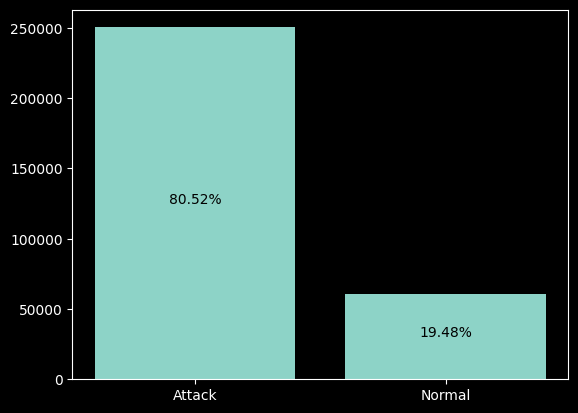

label
attack    250436
normal     60593
Name: count, dtype: int64

In [4]:
# Visualize class imbalance
plt.bar(["Attack", "Normal"], data["label"].value_counts())
total = len(data)
fraud_percentage = (data["label"].value_counts()[1] / total) * 100
normal_percentage = (data["label"].value_counts()[0] / total) * 100

plt.text(0, data["label"].value_counts()[0] / 2, f'{normal_percentage:.2f}%', ha='center', color='black')
plt.text(1, data["label"].value_counts()[1] / 2, f'{fraud_percentage:.2f}%', ha='center', color='black')

plt.show()

data.label.value_counts()

In [5]:
# define numerical cols
num_cols = data.drop(categorical_cols, axis=1)

# Preprocessing pipeline for categorical and numerical data
preprocessor = ColumnTransformer(
	transformers=[
		('num', StandardScaler(), num_cols.drop('label', axis=1).columns),
		('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False, dtype="int8") # bool/int8 saves 2.66x RAM vs int64
   				 ,categorical_cols)
	]
)

# Encode labels (LabelEncoder is not part of the pipeline but applied directly to y)
le = LabelEncoder()
y = le.fit_transform(y)

# create training and test partitions with 80-20 split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [6]:
search_space_random_tuned = {
     # general params
    'xgb__objective': ['binary:logistic'], # logistic regression for binary classification, output probability
    # tree booster params
    'xgb__max_leaves': [0, 2**6, 2**8], # default 0
    'xgb__learning_rate': [0.002, 0.1, 0.3], # alias: eta, step size
    'xgb__gamma': [0.1, 0.3], # min loss reduction to create new tree split
    'xgb__max_depth': [6, 12, 20, 25], # max depth of tree
    'xgb__subsample': [0.4, 0.7, 1],
    'xgb__colsample_bytree': [0.4, 0.5, 0.7, 1], # subsample ratio of columns when constructing each tree
    'xgb__reg_alpha': [0, 0.9, 1], # l1 regularization term on weights, default = 0
    'xgb__reg_lambda': [0.3, 1], # l2 regularization term on weights, default = 1
    'xgb__scale_pos_weight': [1, 2, 4, 580], # control balance of positive and negative weights, useful for unbalanced classes. recommended to start with sum(negative instances) / sum(positive instances)
    'xgb__n_estimators': [100, 170, 500, 700, 1000, 2000, 5000],
	'xgb__eval_metric': ['aucpr'],
    'xgb__booster': ['gbtree'],
    'xgb__tree_method': ['hist'],
}

# Vanilla XGBoost
vanilla_xgb_pipeline = Pipeline([
	('preprocessor', preprocessor),
    ('xgb', XGBClassifier())  # Default XGBoost classifier
])

# RandomizedSearchCV XGBoost
random_search_xgb = Pipeline([
	('preprocessor', preprocessor),
    ('xgb', XGBClassifier())
])

# SPE boosted XGBoost
spe_boosted_xgb_pipeline = Pipeline([
	('preprocessor', preprocessor),
	('spe_xgb', SPEClassifier(estimator=XGBClassifier()))
])

# 10-fold cross-validation setup
cv = StratifiedKFold(n_splits=10)

# Randomized search
random_search = RandomizedSearchCV(
    estimator=random_search_xgb,
    param_distributions=search_space_random_tuned,
    n_iter=10,
    cv=cv, # 10-fold stratified cross-validation
    verbose=1,
    n_jobs=-1,
    random_state=42
)

In [7]:
# Run random search on XGBoost and fit to training data
print("Running RandomizedSearchCV for XGBoost...")
random_search.fit(X_train, y_train)

# Best parameters from random search
best_params = random_search.best_params_
print(f"Best parameters from RandomizedSearchCV: {best_params}")

# Best estimator from RandomizedSearchCV
best_xgb_model = random_search.best_estimator_

models = [
    ('Vanilla XGBoost', vanilla_xgb_pipeline),
    ('RandomizedSearchCV XGBoost', best_xgb_model),
    ('SPE-Boosted XGBoost', spe_boosted_xgb_pipeline)
]

# Define custom scoring methods
scoring_metrics = {
    'precision': make_scorer(precision_score, average='binary'),
    'recall': make_scorer(recall_score, average='binary'),
    'f1': make_scorer(f1_score, average='binary')
}

Running RandomizedSearchCV for XGBoost...
Fitting 10 folds for each of 10 candidates, totalling 100 fits
Best parameters from RandomizedSearchCV: {'xgb__tree_method': 'hist', 'xgb__subsample': 0.4, 'xgb__scale_pos_weight': 1, 'xgb__reg_lambda': 1, 'xgb__reg_alpha': 0.9, 'xgb__objective': 'binary:logistic', 'xgb__n_estimators': 1000, 'xgb__max_leaves': 64, 'xgb__max_depth': 25, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.1, 'xgb__colsample_bytree': 1, 'xgb__booster': 'gbtree'}


In [8]:
# Evaluation loop
for model_name, model in models:
    print('-----------------------------------------------------')
    print(f"\nEvaluating {model_name}...")

    # Perform cross-validation for each scoring metric
    precision_scores = cross_val_score(model, X_train, y_train, cv=10, scoring=scoring_metrics['precision'])
    print(f"Precision scores: {precision_scores}")
    recall_scores = cross_val_score(model, X_train, y_train, cv=10, scoring=scoring_metrics['recall'])
    print(f"Recall scores: {recall_scores}")
    f1_scores = cross_val_score(model, X_train, y_train, cv=10, scoring=scoring_metrics['f1'])
    print(f"F1 scores: {f1_scores}")

    # Calculate mean and standard deviation for each metric
    precision_mean, precision_std = np.mean(precision_scores), np.std(precision_scores)
    recall_mean, recall_std = np.mean(recall_scores), np.std(recall_scores)
    f1_mean, f1_std = np.mean(f1_scores), np.std(f1_scores)

    # Print cross-validation results
    print(f"\nCross-Validation Results for {model_name}:")
    print(f"Precision: {precision_mean:.4f} ± {precision_std:.4f}")
    print(f"Recall: {recall_mean:.4f} ± {recall_std:.4f}")
    print(f"F1-Score: {f1_mean:.4f} ± {f1_std:.4f}")

    # Fit the model on the full training data
    model.fit(X_train, y_train)
    
    # Test set evaluation
    y_pred = model.predict(X_test)
    
    print(f"\nTest Set Classification Report for {model_name}:")
    # Convert back the integer predictions to the original labels using the LabelEncoder
    y_test_labels = le.inverse_transform(y_test)
    y_pred_labels = le.inverse_transform(y_pred)

	# Explicitly define the target names as string labels
    target_names = ['normal', 'attack']

	# Print the classification report using the original labels
    print(classification_report(y_test_labels, y_pred_labels, target_names=target_names))

-----------------------------------------------------

Evaluating Vanilla XGBoost...
Precision scores: [nan nan nan nan nan nan nan nan nan nan]
Recall scores: [0.94616337 0.95214521 0.94678218 0.94800908 0.94594595 0.94945327
 0.95440479 0.93563029 0.95213534 0.94533828]
F1 scores: [0.95057507 0.94590164 0.94972067 0.95203564 0.94858798 0.94925743
 0.95116686 0.95263103 0.94929548 0.94807613]

Cross-Validation Results for Vanilla XGBoost:
Precision: nan ± nan
Recall: 0.9476 ± 0.0049
F1-Score: 0.9497 ± 0.0019

Test Set Classification Report for Vanilla XGBoost:
              precision    recall  f1-score   support

      normal       0.99      0.99      0.99     25043
      attack       0.95      0.95      0.95      6060

    accuracy                           0.98     31103
   macro avg       0.97      0.97      0.97     31103
weighted avg       0.98      0.98      0.98     31103

-----------------------------------------------------

Evaluating RandomizedSearchCV XGBoost...
Precision